In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from collections import Counter
from multiprocessing import Pool
import itertools
import numpy as np
from nltk.tokenize import RegexpTokenizer

In [18]:
df = pd.read_parquet('/Users/Jun/Desktop/vaccine project/covid_sentiment.parquet', engine='pyarrow')
original = pd.read_parquet('/Users/Jun/Desktop/vaccine project/Nov_Data_merged.parquet', engine='pyarrow')

In [19]:
df['time'].unique()


array(['2021-11-01T10:03:04.000Z', '2021-11-01T10:03:03.000Z',
       '2021-11-01T10:03:02.000Z', ..., '2021-11-01T14:13:43.000Z',
       '2021-11-01T14:13:42.000Z', '2021-11-01T14:13:41.000Z'],
      dtype=object)

In [20]:
original['time'].unique()

array(['2021-11-01T10:03:04.000Z', '2021-11-01T10:03:03.000Z',
       '2021-11-01T10:03:02.000Z', ..., '2021-11-01T14:13:43.000Z',
       '2021-11-01T14:13:42.000Z', '2021-11-01T14:13:41.000Z'],
      dtype=object)

/var/folders/nl/hld_9gw91j773h728v6fsq1h0000gn/T/ipykernel_20665/3855975275.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time'].dt.to_period('M')


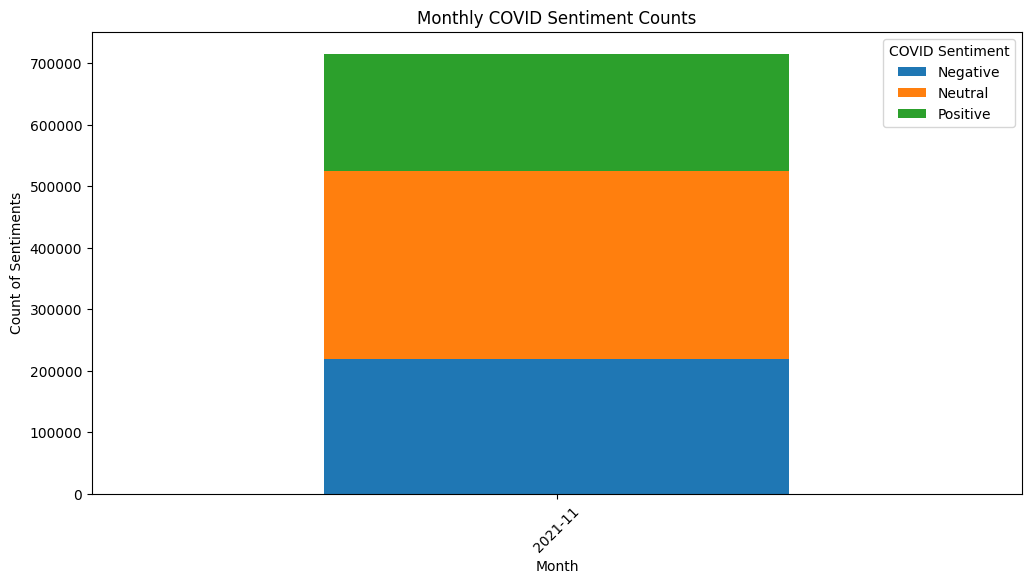

In [6]:
df['time'] = pd.to_datetime(df['time'])
df['year_month'] = df['time'].dt.to_period('M')
df['covid_sentiment'] = df['covid_sentiment'].astype('category')
sentiment_counts = df.groupby(['year_month', 'covid_sentiment']).size().unstack(fill_value=0)
sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Month')
plt.ylabel('Count of Sentiments')
plt.title('Monthly COVID Sentiment Counts')
plt.xticks(rotation=45)
plt.legend(title='COVID Sentiment')
plt.savefig('sentiment_distribution_bar.png', dpi=300) 
plt.show()

/var/folders/nl/hld_9gw91j773h728v6fsq1h0000gn/T/ipykernel_20665/475293553.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time'].dt.to_period('M')


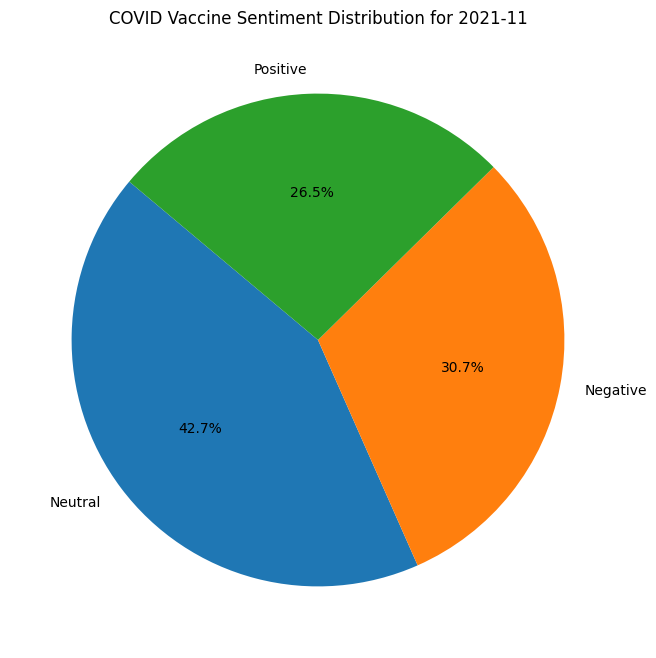

In [7]:
df['time'] = pd.to_datetime(df['time'])
df['year_month'] = df['time'].dt.to_period('M')
df['covid_sentiment'] = df['covid_sentiment'].astype('category')
specific_month = '2021-11'
monthly_data = df[df['year_month'] == specific_month]
sentiment_counts = monthly_data['covid_sentiment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'COVID Vaccine Sentiment Distribution for {specific_month}')
plt.savefig('sentiment_distribution_pie.png', dpi=300) 
plt.show()

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/Jun/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/Jun/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
def process_chunk(chunk):
    tokens = word_tokenize(chunk)
    tokens = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]
    return tokens
def parallelize_text_processing(df, func, n_cores=10):
    df_split = np.array_split(df['text'], n_cores)
    pool = Pool(n_cores)
    tokens = pool.map(func, df_split)
    pool.close()
    pool.join()
    return list(itertools.chain(*tokens))

sample_df = df.sample(frac=0.1)
tokens = parallelize_text_processing(sample_df, process_chunk)
word_freq = Counter(tokens)
top_words = word_freq.most_common(10)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
top_words_df.plot(kind='bar', x='Word', y='Frequency', legend=False, figsize=(10, 6))
plt.title('Top 10 Frequent Words in Text')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig('top10words.png', dpi=300) 
plt.show()

Process SpawnPoolWorker-9:
Traceback (most recent call last):
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'process_chunk' on <module '__main__' (built-in)>
Process SpawnPoolWorker-13:
Traceback (most recent call last):
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*sel

KeyboardInterrupt: 

In [17]:
stop_words = set(stopwords.words('english'))

def process_chunk(chunk):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(chunk.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

def parallelize_text_processing(text_series, func, n_cores=10):
    pool = Pool(n_cores)
    size = len(text_series) // n_cores + 1
    chunks = [text_series.iloc[i:i + size] for i in range(0, text_series.shape[0], size)]
    tokens = pool.map(func, chunks)
    pool.close()
    pool.join()
    return list(itertools.chain(*tokens))

sample_df = df.sample(frac=0.1) 
tokens = parallelize_text_processing(sample_df['text'], process_chunk)
word_freq = Counter(tokens)
top_words = word_freq.most_common(10)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
top_words_df.plot(kind='bar', x='Word', y='Frequency', legend=False, figsize=(10, 6))
plt.title('Top 10 Frequent Words in Text')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig('top10words.png', dpi=300)
plt.show()

Process SpawnPoolWorker-51:
Traceback (most recent call last):
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'process_chunk' on <module '__main__' (built-in)>
Process SpawnPoolWorker-50:
Traceback (most recent call last):
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/Jun/miniconda3/envs/psych750/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*se

KeyboardInterrupt: 